# Accuinsight+ Modeler AutoDL tutorial
## 한글 텍스트를 분류하는 CNN 모델  
## 목차
1. [분석 개요](#1.분석개요)
2. [데이터](#2.데이터)
3. [CNN 모델 생성 및 학습](#3.CNN모델구성및학습)
4. [학습 결과 시각화](#학습_결과_시각화)
5. [모델 평가](#모델_평가)
6. [Modeler AutoDL 사용방법](#AutoDL_사용방법)

<a id='1.분석개요'></a>
## 분석 개요
- 본 예제에서는 네이버 영화 리뷰를 긍정, 부정 리뷰로 분류하는 CNN 모델을 만들고,  
  Accuinsight+ Modeler의 AutoDL 기능을 사용하여 하이퍼파라미터를 최적화하는 과정을 설명합니다.
- [autodl_cnn_review_text_classification_preprocessing.ipynb](autodl_cnn_review_text_classification_preprocessing.ipynb)에서 간단한 전처리 과정을 거친 데이터를 입력 값으로 사용합니다.
- tensorflow 2.0 버전으로 [Kim(2014)](http://emnlp2014.org/papers/pdf/EMNLP2014181.pdf)을 구현한 코드로, 다음의 출처를 참고하여 코드를 재구성했습니다. ([출처1](https://github.com/ShaneTian/TextCNN), [출처2](https://wikidocs.net/77511))
<p align="center">
    <img src="pic/TextCNN.png" height="300px" width="800px">
</p>

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.callbacks import Callback
from konlpy.tag import Okt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import easydict

- 이번 예제에서 최적화할 하이퍼파라미터는 아래와 같습니다.
  - `sequence_length`: 토큰 리스트의 최대 길이
  - `embed_size`: 토큰을 임베딩할 차원의 수
  - `filter_sizes`: 필터의 크기
  - `num_filters`: 각각의 필터 개수
  - `dropout_rate`: 모델의 일반화를 위해 layer에서 일부 노드만을 무작위로 선택하는 dropout 기법을 사용하는데, 이 때 선택되는 노드의 비율
  - `learning_rate`: 경사하강법을 통해 모델을 학습시키는 데 사용되는 스칼라값으로, 각 반복에서 경사에 곱해지는 값
  - `batch_size`: 모델 학습의 반복 한 회당 사용되는 샘플의 개수
- AutoDL을 사용하기 위해서는 __argparse__를 통해 하이퍼파라미터를 설정해야 하는데,  
  jupyter notebook에서는 argparse 사용이 불가능하기 때문에 __easydict__를 통해 하이퍼파라미터를 설정합니다.  
  실제로 AutoDL에 사용되는 [autodl_cnn_review_text_classification.py](autodl_cnn_review_text_classification.py)에서는 argparse를 통해 하이퍼파라미터를 설정합니다.

In [2]:
args = easydict.EasyDict({
    "sequence_length": 150,
    "embed_size": 128,
    "filter_sizes": "3,4,5",
    "num_filters": 128,
    "dropout_rate": 0.5,
    "regularizers_lambda": 0.01,
    "learning_rate": 0.0001,
    "batch_size": 128,
    "epochs": 20})

<a id='2.데이터'></a>
## 데이터

#### Okt 형태소 분석기를 사용해 문장을 토큰화
- 주어진 문장을 토큰화한 list를 반환하는 함수입니다.
- 예를 들어, 어떤 문장이 토큰의 나열로 표현되는 과정은 다음과 같습니다.  
  1) __원본 문장__: ['스토리가 맘에 들었습니다 추천합니다']  
  2) okt.morphs(['스토리가 맘에 들었습니다 추천합니다'])  
  3) ' '.join(['스토리', '가', '맘', '에', '들었습니다', '추천', '합니다'])  
  4) __토큰의 나열__: ['스토리 가 맘 에 들었습니다 추천 합니다']

In [3]:
def make_morphs_list(documents):
    okt=Okt()
    morphs_list = []
    for i, document in enumerate(documents):
        clean_words = []
        for word in okt.morphs(document): 
            clean_words.append(word)
        document = ' '.join(clean_words)
        morphs_list.append(document)

    return morphs_list

#### 단어 사전 생성
- 주어진 텍스트에 등장하는 모든 단어로 생성한 `word_to_index` 딕셔너리와 단어의 개수 `vocab_size`를 반환하는 함수입니다.
- 텍스트를 CNN 모델의 입력 값으로 사용할 수 있도록 단어에 인덱스를 부여하는 과정입니다.

In [4]:
PADDING = "<PADDING>"  # Zero padding
OOV = "<OOV>" # Out Of Vocabulary

def make_dictionary(documents):
    words = []

    for document in documents:
        for word in document.split():
            words.append(word)

    # 길이가 0인 단어를 삭제합니다.
    words = [word for word in words if len(word) > 0]

    # 중복된 단어를 삭제합니다.
    words = list(set(words))
    
    # 단어 사전의 제일 앞에 태그 단어를 삽입합니다.
    # 단어 사전에서 PADDING의 인덱스는 0, OOV의 인덱스는 1이 됩니다.
    words = [PADDING, OOV] + words
    
    vocab_size = len(words)

    # 단어 사전 word_to_index를 생성합니다.
    word_to_index = {word: index for index, word in enumerate(words)}
    
    return word_to_index, vocab_size

#### 리뷰 문장을 CNN 모델의 입력 값으로 변형
- 문장을 인덱스 배열로 변환하고, 이를 저장한 `documents_index` 리스트를 반환하는 함수입니다.
- 예를 들어 args.sequence_length=10이고 토큰의 개수가 7개인 경우 다음과 같이 변환됩니다.  
  스토리 가 맘 에 들었습니다 추천 합니다 -> [4, 12, 7, 6, 32, 21, 41, 0, 0, 0]

In [5]:
def convert_word_to_index(documents, word_to_index):
    documents_index = []

    # 모든 문장에 대해서 반복합니다.
    for document in documents:
        document_index = []

        # 문장의 단어들을 띄어쓰기로 분리합니다.
        for word in document.split():
            if word_to_index.get(word) is not None:
                # 사전에 있는 단어이면 해당 인덱스를 추가합니다.
                document_index.append(word_to_index[word])
            else:
                # 사전에 없는 단어이면 OOV 인덱스를 추가합니다.
                document_index.append(word_to_index[OOV])

        # 최대 길이(arg.sequence_length)를 확인합니다.
        if len(document_index) > args.sequence_length:
            document_index = document_index[:args.sequence_length]

        # 최대 길이보다 짧은 문장은 남는 토큰(최대 길이-문장의 토큰 개수)만큼을 PADDING 인덱스로 채웁니다.
        document_index += [word_to_index[PADDING]] * (args.sequence_length - len(document_index))

        # 문장의 인덱스 배열을 document_index 리스트에 추가합니다.
        documents_index.append(document_index)

    return np.asarray(documents_index)

#### 라벨 데이터를 one-hot encoding
- 모델에 입력하기 위해 긍정, 부정 라벨을 one-hot encoding하는 함수 입니다.
- 부정 라벨(0)은 [1, 0]으로, 긍정 라벨(1)은 [0, 1]로 encoding합니다.

In [6]:
def label_one_hot_encoding(label):
    results = np.zeros((len(label), 2))
    for idx, l in enumerate(label):
        if l == 0: # negative
            results[idx] = [1, 0]
        else: # positive
            results[idx] = [0, 1]
    return results

데이터를 불러옵니다.

In [7]:
df = pd.read_csv("data/ratings_preprocessed.csv", sep='\t')
documents = make_morphs_list(df['document'].values)
word_to_index, vocab_size = make_dictionary(documents)
documents_index = convert_word_to_index(documents, word_to_index)
labels = label_one_hot_encoding(df['label'].values)

In [8]:
print("총 데이터 개수: ", len(labels))
print("train 데이터 개수: ", int(len(labels)*0.8))
print("test 데이터 개수: ", len(labels)-int(len(labels)*0.8))

총 데이터 개수:  65329
train 데이터 개수:  52263
test 데이터 개수:  13066


In [9]:
X_train, Y_train = documents_index[:52263], labels[:52263]
X_test, Y_test = documents_index[52263:], labels[52263:]

<a id='3.CNN모델구성및학습'></a>
## CNN 모델 생성 및 학습
- 입력 값은 문장을 인덱스 배열로 변환한 값입니다.  
  ex) [4, 12, 7, 6, 32, 21, 41, 0, 0, 0]
- 처음에는 랜덤하게 입력 값을 임베딩한 후 학습을 통해 업데이트합니다.  
  ex) [4, 12, 7, 6, 32, 21, 41, 0, 0, 0] -> [0.2, 0.32, -0.97, 0.1, -0.2, 0.44, 0.8, 0, 0, 0]
- 임베딩한 값은 3, 4, 5 사이즈의 필터(각각 128개)를 거치고, 그 결과 값을 concatenate한 뒤 분류를 수행합니다.

In [10]:
def TextCNN(vocab_size, sequence_length, embed_size, num_classes, num_filters,
            filter_sizes, regularizers_lambda, dropout_rate):

    inputs = keras.Input(shape=(sequence_length,), name='input_data')
    embed = keras.layers.Embedding(vocab_size, embed_size,
                                   embeddings_initializer=keras.initializers.RandomUniform(minval=-1, maxval=1),
                                   input_length=sequence_length,
                                   name='embedding')(inputs)

    embed = keras.layers.Reshape((sequence_length, embed_size, 1), name='add_channel')(embed)

    pool_outputs = []
    for filter_size in list(map(int, filter_sizes.split(','))):
        filter_shape = (filter_size, embed_size)
        conv = keras.layers.Conv2D(num_filters, filter_shape, strides=(1, 1), padding='valid',
                                   data_format='channels_last', activation='relu',
                                   kernel_initializer='glorot_normal',
                                   bias_initializer=keras.initializers.constant(0.1),
                                   name='convolution_{:d}'.format(filter_size))(embed)
        max_pool_shape = (sequence_length - filter_size + 1, 1)
        pool = keras.layers.MaxPool2D(pool_size=max_pool_shape,
                                      strides=(1, 1), padding='valid',
                                      data_format='channels_last',
                                      name='max_pooling_{:d}'.format(filter_size))(conv)
        pool_outputs.append(pool)

    pool_outputs = keras.layers.concatenate(pool_outputs, axis=-1, name='concatenate')
    pool_outputs = keras.layers.Flatten(data_format='channels_last', name='flatten')(pool_outputs)
    pool_outputs = keras.layers.Dropout(dropout_rate, name='dropout')(pool_outputs)

    outputs = keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_initializer='glorot_normal',
                                 bias_initializer=keras.initializers.constant(0.1),
                                 kernel_regularizer=keras.regularizers.l2(regularizers_lambda),
                                 bias_regularizer=keras.regularizers.l2(regularizers_lambda),
                                 name='dense')(pool_outputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = TextCNN(vocab_size, args.sequence_length, args.embed_size, 2,
                args.num_filters, args.filter_sizes, args.regularizers_lambda, args.dropout_rate)
model.summary()
model.compile(keras.optimizers.Adam(lr=args.learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 128)     8233600     input_data[0][0]                 
__________________________________________________________________________________________________
add_channel (Reshape)           (None, 150, 128, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
convolution_3 (Conv2D)          (None, 148, 1, 128)  49280       add_channel[0][0]                
______________________________________________________________________________________________

- AutoDL에서 평가 지표를 수집할 수 있도록 epoch이 종료될 때마다 평가 지표(Accuracy)를 출력합니다.
- 이번 예제에서는 __평가 지표명=평가 지표값__ 형식으로 평가 지표를 출력하는데,  
  평가 지표 설정 방법은 [Modeler AutoDL 사용방법](#AutoDL_사용방법) 챕터에서 좀 더 자세히 다룰 것입니다.

In [11]:
class MetricHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("\nEpoch {}".format(epoch + 1))
        print("Train-acc={:.4f}".format(logs['accuracy']))
        print("Validation-acc={:.4f}".format(logs['val_accuracy']))

모델을 학습시킵니다.

In [12]:
history = model.fit(x=X_train, y=Y_train,
                    batch_size=args.batch_size,
                    epochs=args.epochs,
                    validation_split=0.25,
                    shuffle=True,
                    callbacks=[MetricHistory()])

Epoch 1/20
307/307 [==============================] - ETA: 0s - loss: 0.7044 - accuracy: 0.5894
Epoch 1
Train-acc=0.5894
Validation-acc=0.6861
307/307 [==============================] - 45s 146ms/step - loss: 0.7044 - accuracy: 0.5894 - val_loss: 0.6462 - val_accuracy: 0.6861
Epoch 2/20
307/307 [==============================] - ETA: 0s - loss: 0.6230 - accuracy: 0.6856
Epoch 2
Train-acc=0.6856
Validation-acc=0.7151
307/307 [==============================] - 48s 157ms/step - loss: 0.6230 - accuracy: 0.6856 - val_loss: 0.5998 - val_accuracy: 0.7151
Epoch 3/20
307/307 [==============================] - ETA: 0s - loss: 0.5708 - accuracy: 0.7263
Epoch 3
Train-acc=0.7263
Validation-acc=0.7337
307/307 [==============================] - 49s 159ms/step - loss: 0.5708 - accuracy: 0.7263 - val_loss: 0.5691 - val_accuracy: 0.7337
Epoch 4/20
307/307 [==============================] - ETA: 0s - loss: 0.5326 - accuracy: 0.7567 ETA: 1s - loss: 0.533
Epoch 4
Train-acc=0.7567
Validation-acc=0.7469
307/

<a id='학습_결과_시각화'></a>
## 학습 결과 시각화

모델의 학습 과정 그래프를 그리는 함수입니다.

In [13]:
def evaluate_model(history, X_test, y_test, model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Model - Accuracy')
    ax[0].legend(['Training', 'Validation'], loc='lower right')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Model - Loss')
    ax[1].legend(['Training', 'Validation'], loc='upper right')
    plt.show()

Accuracy: 80.02%


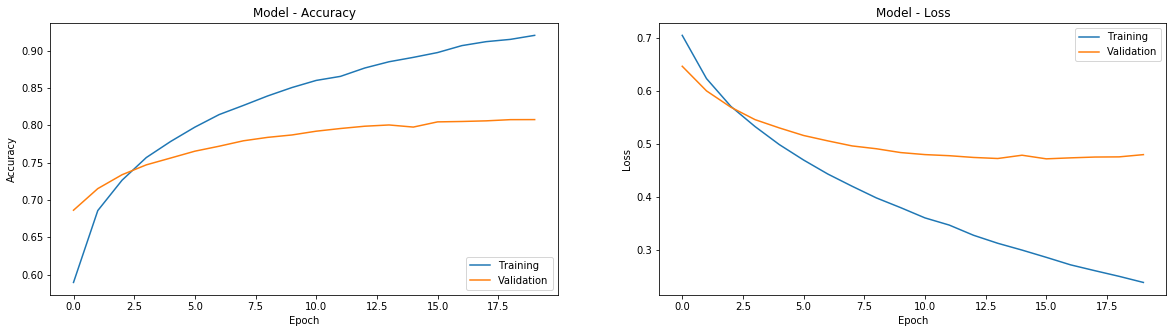

In [14]:
evaluate_model(history, X_test, Y_test, model)

<a id='모델_평가'></a>
## 모델 평가

학습한 모델에 임의의 문장을 입력하여 모델을 평가합니다.

In [15]:
# 모델을 평가할 문장은 list로 작성합니다.
test_sentence = ["시간 아까웠음 비추천", "뭘 말하고 싶은건지 모르겠다", "연기가 좋았습니다", "너무 감동적이었어요"] 
morphs = make_morphs_list(test_sentence)
documents_index = convert_word_to_index(morphs, word_to_index)

pred = model.predict((documents_index), verbose=0)
pred_label = np.argmax(pred, 1)

for i, s in enumerate(test_sentence):
    if pred_label[i] == 0:
        print(test_sentence[i], "- 부정 리뷰입니다.")
    else:
        print(test_sentence[i], "- 긍정 리뷰입니다.")

시간 아까웠음 비추천 - 부정 리뷰입니다.
뭘 말하고 싶은건지 모르겠다 - 부정 리뷰입니다.
연기가 좋았습니다 - 긍정 리뷰입니다.
너무 감동적이었어요 - 긍정 리뷰입니다.


<a id='AutoDL_사용방법'></a>
## Modeler AutoDL 사용방법
- 지금까지 영화 리뷰의 감정을 분류하는 TextCNN 모델 예제를 살펴보았습니다.
- 이번 챕터에서는 위에서 살펴본 CNN 모델의 하이퍼파라미터를 AutoDL 기능을 사용해 최적화하는 과정에 대해 다룰 것입니다.